In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [31]:
# Load the dataset
marc_anne_data = pd.read_excel("Marc_Anne_HR_Variability_MSA.xlsx")
deltas_pas_pad = pd.read_csv("Deltas_PAS_PAD.txt", sep=",")

In [32]:
# Convert date columns to datetime
marc_anne_data['Date_de_l_examen'] = pd.to_datetime(marc_anne_data['Date_de_l_examen'])
marc_anne_data['date_'] = pd.to_datetime(marc_anne_data['date_'])

In [33]:
# Calculate follow-up duration
marc_anne_data['Followup_duration'] = (marc_anne_data['Date_de_l_examen'] - marc_anne_data['date_']).dt.days / 365.25

In [34]:
# Merge with Deltas_PAS_PAD dataset
marc_anne_data = pd.merge(marc_anne_data, deltas_pas_pad, how='left', on='patid')

In [35]:
marc_anne_data.columns

Index(['patid', 'Sexe_', 'DDN', 'Date_de_l_examen', 'Age_lors_de_l_examen',
       'ms/mmHg', 'Mean_RR_(ms)', 'pNN50_(%)', 'SDNN_(ms)', 'rMSSD_(ms)',
       ...
       'COMPASS_score_secretomoteur', 'COMPASS_score_gastro-intestinal',
       'COMPASS_score_vessie', 'COMPASS_score_pupillomoteur', 'fin_de_suivi_',
       'cause', 'date_', 'Followup_duration', 'Delta_PAS', 'Delta_PAD'],
      dtype='object', length=190)

In [36]:

# If column names have special characters (e.g., / or -), rename them
marc_anne_data.columns = marc_anne_data.columns.str.replace("-", "_").str.replace("/", "_")

# Select the desired range of columns and additional columns for processing
cols_to_select = list(marc_anne_data.loc[:, "ms_mmHg":"Hurst"].columns)  # Select range from 'ms_mmHg' to 'Hurst'
additional_cols = ["Score_UMSARS1", "Score_UMSARS2"]
final_columns = cols_to_select + additional_cols

# Select relevant columns
marc_anne_data = marc_anne_data[final_columns]



In [38]:
# Create the UMSARS score and drop unused columns
marc_anne_data['UMSARS'] = marc_anne_data['Score_UMSARS1'] + marc_anne_data['Score_UMSARS2']
marc_anne_data = marc_anne_data.drop(columns=['Score_UMSARS1', 'Score_UMSARS2'])

In [39]:
marc_anne_data

,ms_mmHg,Mean_RR_(ms),pNN50_(%),SDNN_(ms),rMSSD_(ms),Ptot_(ms²),VLF_(ms²),LF_(ms²),HF_(ms²),LF_HF,pLF1_(ms²),pLF2_(ms²),pHF1_(ms²),pHF2_(ms²),IMAI1,IMAI2,Triangular_index,TINN_(ms),X_(ms),Y_(beats),M_(ms),N_(ms),Approximate_Entropy,Sample_Entropy,Shanon_Entropy_(SE),Conditional_Entropy_(CE),Corrected_CE_(CCE),Normalized_CCE_(NCCE),ρ,Lempel_Ziv_Complexity_(LZC),Centroid_(ms),SD1_(ms),SD2_(ms),SD1_SD2,OV,OV%,1V,1V%,2V,2V%,2UV,2UV%,MP,MP%,α1_(DFA),α2_(DFA),H_(DFA),H_(Higuchi),H_(Katz),Hurst,UMSARS
0,3.493,890.0,0.30,26.7,20.1,314.62,103.33,107.52,43.01,2.50,40.66,26.84,26.00,112.86,0.293,0.193,9.80,148.0,883.0,34.0,969.0,820.0,1.09,1.18,3.76,0.98,1.03,0.66,0.34,0.90,890.0,14.19,35.07,0.405,51.0,15.32,134.0,40.24,8.0,2.40,140.0,42.04,155.0,46.55,0.852,0.917,1.108,1.933,1.935,0.089,91.0
1,3.643,823.0,0.00,17.7,11.7,173.99,115.06,26.76,21.15,1.27,32.88,59.23,20.42,42.86,0.520,0.935,7.28,117.0,828.0,50.0,875.0,758.0,1.12,1.55,3.64,0.97,1.04,0.68,0.32,1.03,823.0,8.30,23.57,0.352,87.0,24.03,162.0,44.75,13.0,3.59,100.0,27.62,156.0,43.09,0.858,1.133,1.103,1.864,1.611,0.206,33.0
2,2.866,770.0,0.00,13.0,7.7,162.24,107.36,21.60,19.38,1.11,7.37,13.61,8.22,26.35,0.213,0.394,5.78,94.0,773.0,63.0,813.0,719.0,1.19,1.57,3.21,0.89,0.93,0.67,0.33,0.96,770.0,5.48,17.63,0.311,115.0,31.77,174.0,48.07,14.0,3.87,59.0,16.30,172.0,47.51,1.059,1.152,1.076,1.850,1.452,0.220,35.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0
4,5.445,777.0,0.52,15.4,13.6,125.40,42.87,18.08,33.09,0.55,14.10,19.04,42.13,61.14,0.136,0.184,6.19,102.0,781.0,62.0,828.0,727.0,1.20,1.60,3.84,1.10,1.16,0.78,0.22,0.98,778.0,9.62,19.27,0.499,84.0,21.33,173.0,45.17,30.0,7.83,96.0,25.07,131.0,34.20,0.776,0.993,0.949,1.937,1.635,0.101,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,5.589,743.0,0.74,26.2,15.9,835.28,404.84,374.62,28.00,13.38,130.02,243.14,89.41,119.57,0.622,1.163,7.72,117.0,742.0,52.0,805.0,688.0,1.06,1.20,2.33,0.58,0.59,0.53,0.47,1.10,743.0,8.68,34.82,0.249,252.0,62.84,122.0,30.42,3.0,0.75,24.0,5.99,184.0,45.89,1.611,0.921,0.866,1.510,1.617,0.406,53.0
210,4.503,636.0,0.00,16.3,3.4,99.71,83.05,5.77,2.78,2.08,2.75,18.70,3.50,4.39,0.348,2.371,6.51,102.0,633.0,72.0,695.0,594.0,0.67,0.65,2.83,0.58,0.59,0.37,0.63,1.00,636.0,2.40,22.85,0.105,282.0,60.13,138.0,29.42,0.0,0.00,49.0,10.45,182.0,38.81,1.170,1.546,1.400,1.741,1.220,0.304,NaN
211,5.670,780.0,0.00,12.0,13.4,97.03,20.20,34.33,22.38,1.53,18.81,16.74,15.05,60.36,0.249,0.222,5.58,86.0,781.0,69.0,820.0,734.0,1.23,2.16,3.67,1.09,1.12,0.84,0.16,0.99,780.0,9.53,14.11,0.675,56.0,14.66,164.0,42.93,20.0,5.24,142.0,37.17,143.0,37.43,0.640,0.818,0.879,1.986,1.670,0.060,NaN
212,8.816,806.0,4.31,47.1,24.9,1360.73,297.85,667.86,338.70,1.97,282.92,319.71,288.43,561.98,0.333,0.376,13.44,211.0,828.0,28.0,906.0,695.0,0.95,0.89,3.12,0.80,0.87,0.59,0.41,0.99,806.0,17.64,64.44,0.274,172.0,46.61,153.0,41.46,16.0,4.34,28.0,7.59,163.0,44.17,1.150,0.964,0.950,1.574,1.911,0.326,NaN


In [40]:
# Drop rows with missing values
marc_anne_data = marc_anne_data.dropna()

In [41]:
marc_anne_data.shape

(117, 51)

In [42]:
# Clean column names
marc_anne_data.columns = marc_anne_data.columns.str.replace(r"[-/()%²]", "_", regex=True)
marc_anne_data.columns = marc_anne_data.columns.str.replace("1", "one").str.replace("2", "two").str.replace("%", "perc")

In [43]:
# Standardize numeric columns
scaler = StandardScaler()
numeric_cols = marc_anne_data.select_dtypes(include=np.number).columns
marc_anne_data[numeric_cols] = scaler.fit_transform(marc_anne_data[numeric_cols])

<ipython-input-43-11a25d17e0d1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marc_anne_data[numeric_cols] = scaler.fit_transform(marc_anne_data[numeric_cols])


In [44]:
# Split the data into predictors (X) and target (y)
X = marc_anne_data.drop(columns=['UMSARS'])
y = marc_anne_data['UMSARS']

In [45]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [46]:
X_train.head()

,ms_mmHg,Mean_RR__ms_,pNN50____,SDNN__ms_,rMSSD__ms_,Ptot__ms__,VLF__ms__,LF__ms__,HF__ms__,LF_HF,pLFone__ms__,pLFtwo__ms__,pHFone__ms__,pHFtwo__ms__,IMAIone,IMAItwo,Triangular_index,TINN__ms_,X__ms_,Y__beats_,M__ms_,N__ms_,Approximate_Entropy,Sample_Entropy,Shanon_Entropy__SE_,Conditional_Entropy__CE_,Corrected_CE__CCE_,Normalized_CCE__NCCE_,ρ,Lempel_Ziv_Complexity__LZC_,Centroid__ms_,SDone__ms_,SDtwo__ms_,SDone_SDtwo,OV,OV_,oneV,oneV_,twoV,twoV_,twoUV,twoUV_,MP,MP_,αone__DFA_,αtwo__DFA_,H__DFA_,H__Higuchi_,H__Katz_,Hurst
16,0.863440,1.409244,-0.274950,0.663935,0.102413,0.233043,0.181346,0.446997,0.052305,-0.243221,0.895582,0.043124,0.335823,-0.122130,0.098345,-0.454158,0.621316,0.788963,1.294390,-1.111050,1.400807,1.322228,0.259094,0.903526,0.270666,0.417759,0.536106,0.742002,-0.742002,1.090590,1.395536,0.15976,0.998106,-0.311387,-0.530623,-0.262352,-0.122925,0.688932,0.025388,0.213287,-0.423128,-0.195985,-0.259839,0.851173,0.607250,-0.659904,-0.381735,-0.984182,0.366193,0.438834
52,0.318214,-1.340020,-0.307660,-0.978469,-0.497939,-0.617646,-0.639852,-0.501880,-0.312554,-0.055466,-0.599105,-0.556461,-0.439388,-0.264700,-0.480575,-0.521600,-0.868784,-0.986746,-1.119527,1.661696,-1.357259,-1.206298,1.125208,1.617598,0.434783,0.707836,0.448989,0.660715,-0.660715,-1.303193,-1.338115,-0.51051,-1.078068,0.104611,-0.387425,-0.641298,1.778461,0.952885,0.154533,-0.080905,0.746481,0.282660,-0.519235,-1.355133,-0.479687,0.110310,0.002535,0.600836,-0.518961,-0.775591
198,-1.053093,-0.838465,-0.307660,-1.324706,-0.764074,-0.652713,-0.659275,-0.529810,-0.317234,-0.359288,-0.643461,-0.554055,-0.474901,-0.297788,0.010012,0.459677,-0.974277,-0.986746,-0.684231,1.444225,-0.884693,-0.667271,0.022881,-0.554373,0.451195,0.562797,0.318313,0.091708,-0.091708,-0.054263,-0.837718,-0.80830,-1.460542,-0.324387,-0.074993,-0.234166,0.705884,0.307667,0.348252,0.173277,0.296631,0.066111,-0.104202,-0.720852,0.116375,0.391334,-0.644657,-0.295043,-1.018108,0.366975
118,-1.031724,0.350406,-0.221797,-0.285996,-0.033750,-0.107826,0.004541,-0.294935,-0.154221,-0.560697,-0.493107,0.421754,-0.312827,-0.147069,-0.646370,0.255666,-0.424831,-0.310285,0.368395,-0.023699,0.258057,0.400982,-0.055857,0.010935,-2.223907,-1.999542,-1.859617,-1.046306,1.046306,0.674280,0.348409,-0.24473,-0.309023,-0.139138,1.552259,1.882923,-2.121819,-2.303578,-1.072350,-1.059978,-0.827992,-0.764925,1.452174,1.260134,0.835156,1.052261,-0.064881,-0.128502,-0.310429,0.309487
47,0.437578,1.464972,-0.307660,0.592912,0.003386,0.535498,0.631384,0.975415,-0.042686,0.518040,0.407870,1.309020,0.119913,-0.304240,0.754727,1.548861,0.647690,0.563476,1.294390,-1.165417,1.460952,1.479036,0.259094,-0.018818,0.205020,0.272721,0.448989,0.416855,-0.416855,-0.158340,1.460403,0.04433,0.933405,-0.395887,-0.517605,-0.229990,-0.147302,0.701501,0.025388,0.227408,-0.490605,-0.259911,0.258953,1.333069,0.960797,-0.691129,-0.031173,-0.674069,0.295203,0.618483


In [47]:
# 1. Random Forest
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

# Feature importance
rf_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)


In [51]:
# 2. Support Vector Machines (SVM)
svm_model = SVR(kernel='rbf', C=1.0)
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)

svm_mse = mean_squared_error(y_test, svm_predictions)
svm_r2 = r2_score(y_test, svm_predictions)


In [58]:
# 3. Neural Network
nn_model = MLPRegressor(hidden_layer_sizes=(30,), max_iter=1000, random_state=42)
nn_model.fit(X_train, y_train)
nn_predictions = nn_model.predict(X_test)

nn_mse = mean_squared_error(y_test, nn_predictions)
nn_r2 = r2_score(y_test, nn_predictions)


In [61]:
#Print Results
print("Random Forest: MSE = {:.3f}, R^2 = {:.3f}".format(rf_mse, rf_r2))
print("Support Vector Machine: MSE = {:.3f}, R^2 = {:.3f}".format(svm_mse, svm_r2))
print("Neural Network: MSE = {:.3f}, R^2 = {:.3f}".format(nn_mse, nn_r2))


Random Forest: MSE = 1.266, R^2 = -0.118
Support Vector Machine: MSE = 1.221, R^2 = -0.078
Neural Network: MSE = 2.258, R^2 = -0.995


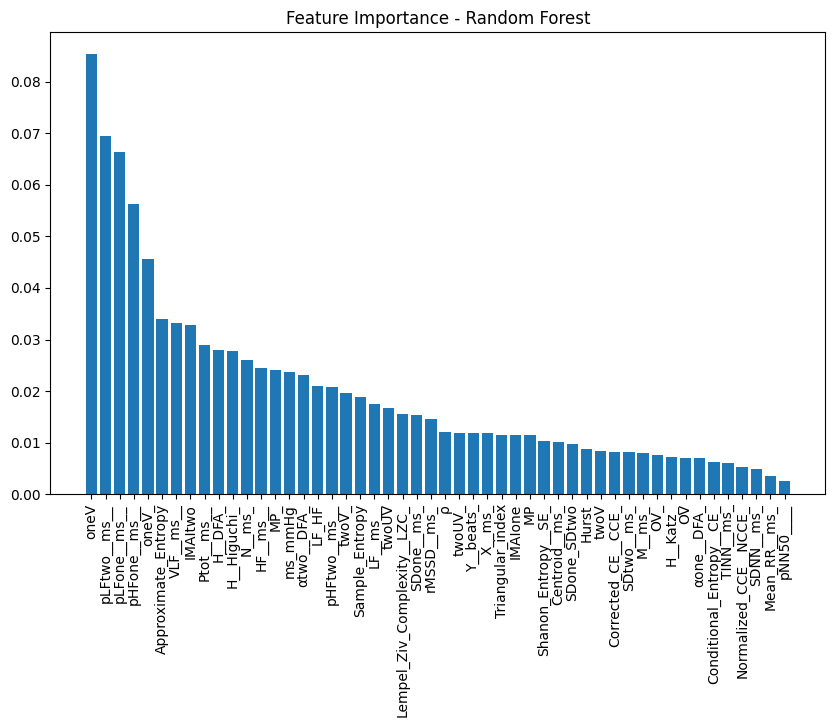

In [62]:
# Plot feature importance for Random Forest
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(rf_feature_importance['Feature'], rf_feature_importance['Importance'])
plt.xticks(rotation=90)
plt.title('Feature Importance - Random Forest')
plt.show()

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Ensure TensorFlow is installed and working
print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.17.1


In [64]:
# Neural Network using TensorFlow/Keras
def build_and_train_nn(X_train, X_test, y_train, y_test):
    # Define the model
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # 1st hidden layer
        Dropout(0.2),  # Dropout to prevent overfitting
        Dense(64, activation='relu'),  # 2nd hidden layer
        Dropout(0.2),  # Dropout to prevent overfitting
        Dense(32, activation='relu'),  # 3rd hidden layer
        Dropout(0.2),
        Dense(1, activation='linear')  # Output layer for regression
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=1000,
        batch_size=32,
        verbose=1
    )

    # Evaluate the model
    y_pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Neural Network: MSE = {mse:.3f}, R^2 = {r2:.3f}")

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Return the trained model and predictions
    return model, y_pred


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - loss: 0.9839 - mae: 0.7647 - val_loss: 1.1268 - val_mae: 0.8998
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.9610 - mae: 0.8079 - val_loss: 1.1204 - val_mae: 0.8975
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.0364 - mae: 0.8298 - val_loss: 1.1006 - val_mae: 0.8864
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.6899 - mae: 0.6604 - val_loss: 1.0720 - val_mae: 0.8760
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.9157 - mae: 0.7473 - val_loss: 1.0478 - val_mae: 0.8704
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.8509 - mae: 0.7263 - val_loss: 1.0379 - val_mae: 0.8678
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.0761 - mae: 0.8173 - val_loss: 1.0324 - val_mae: 0.8682
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.0889 - mae: 0.8175 - val_loss: 1.0244 - val_mae: 0.8662
Epoch 9/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.72

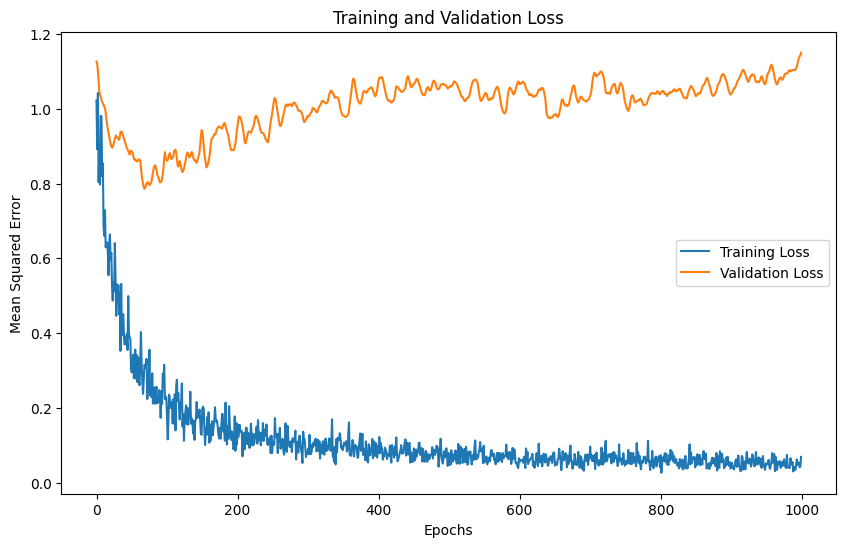

In [65]:

# Train the model
nn_model, nn_predictions = build_and_train_nn(X_train, X_test, y_train, y_test)


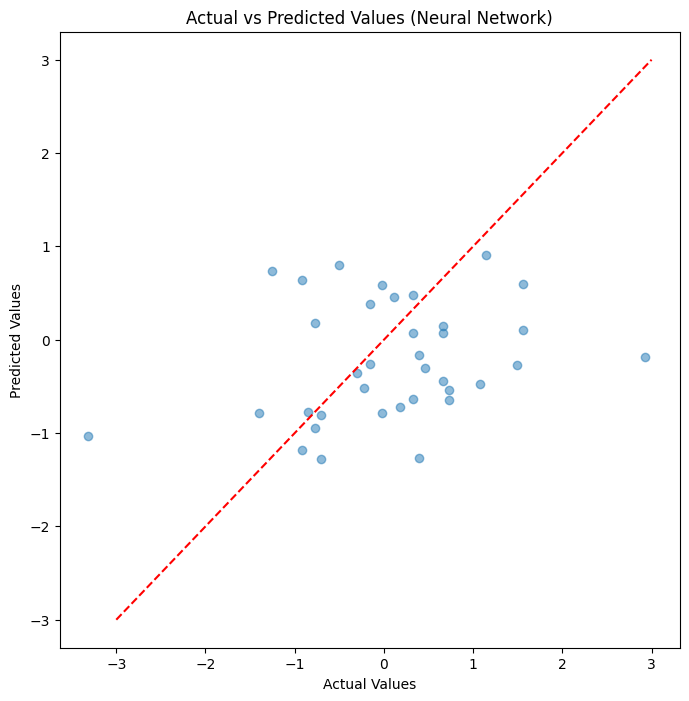

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# RGB values for light blue and light pink
light_blue = (0/255, 135/255, 250/255)  # Light blue: RGB(0, 135, 250)
light_pink = (255/255, 0/255, 79/255)  # Light pink: RGB(255, 0, 79)

# Predicted vs Actual values
plt.scatter(y_test, y_pred, alpha=0.5, color=light_blue)  # Scatter plot with blue dots
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color=light_pink)  # Line of perfect prediction in pink
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()


In [69]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [71]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score

# Define the model building function
def build_nn_model(hp):
    model = Sequential()
    # Input Layer
    model.add(Dense(
        units=hp.Int('units_input', min_value=32, max_value=128, step=32),
        activation='relu', input_shape=(X_train.shape[1],)
    ))
    # Hidden Layers
    for i in range(hp.Int('num_layers', 1, 5)):  # Vary number of hidden layers
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
            activation='relu'
        ))
        model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))
    # Output Layer
    model.add(Dense(1, activation='linear'))  # Regression output
    # Compile Model
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd']),
        loss='mse', metrics=['mae']
    )
    return model

In [72]:

# Hyperparameter tuner
tuner = kt.RandomSearch(
    build_nn_model,
    objective='val_loss',
    max_trials=10,  # Number of models to try
    executions_per_trial=2,  # Average over multiple runs
    directory='my_dir',
    project_name='tune_nn'
)

# Run the search
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, verbose=1)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Optimal Number of Layers: {best_hps.get('num_layers')}
Optimal Units in Input Layer: {best_hps.get('units_input')}
Dropout Rate: {best_hps.get('dropout')}
Optimizer: {best_hps.get('optimizer')}
""")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, validation_split=0.2, epochs=100, verbose=1)

# Evaluate on test set
y_pred = best_model.predict(X_test).flatten()
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Optimized Neural Network: MSE = {mse:.3f}, R^2 = {r2:.3f}")


Trial 10 Complete [00h 00m 14s]
val_loss: 0.8981074392795563

Best val_loss So Far: 0.882472425699234
Total elapsed time: 00h 02m 43s

Optimal Number of Layers: 3
Optimal Units in Input Layer: 128
Dropout Rate: 0.2
Optimizer: adam

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - loss: 2.1883 - mae: 1.1855 - val_loss: 1.1810 - val_mae: 0.9028
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.1373 - mae: 0.8605 - val_loss: 1.1132 - val_mae: 0.8773
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.0127 - mae: 0.8109 - val_loss: 1.0881 - val_mae: 0.8692
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.9272 - mae: 0.7463 - val_loss: 1.0888 - val_mae: 0.8793
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.7688 - mae: 0.7062 - val_loss: 1.0930 - val_mae: 0.8835
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.0330 - mae: 0.8250 - val_loss: 1.0980 - val_mae: 0.8867
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.8846 - mae: 0.7377 - val_loss: 1.0991 - val_mae: 0.8873
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.9161 - mae: 0.7909 - val_loss: 1.0953 - val_mae: 0.8853
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.8190 - mae: 0.7228 - va

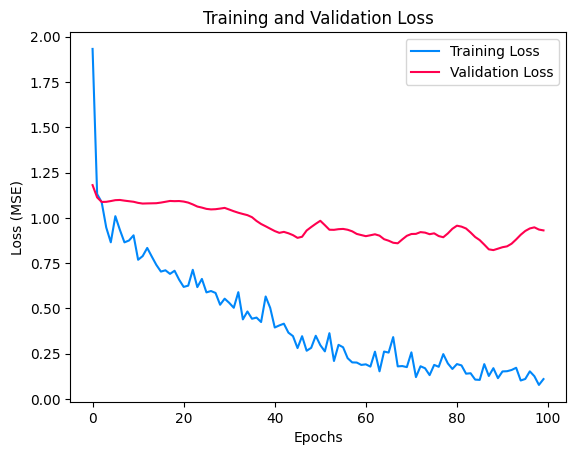

In [117]:
import matplotlib.pyplot as plt



# RGB values for light blue and light pink
light_blue = (0/255, 135/255, 250/255)  # Light blue: RGB(0, 135, 250)
light_pink = (255/255, 0/255, 79/255)  # Light pink: RGB(255, 0, 79)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss', color=light_blue)
plt.plot(history.history['val_loss'], label='Validation Loss',  color=light_pink)
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


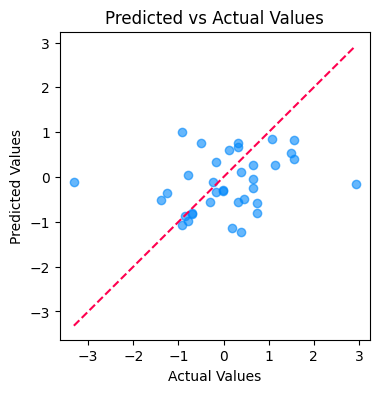

In [120]:
import numpy as np
import matplotlib.pyplot as plt

# RGB values for light blue and light pink
light_blue = (0/255, 135/255, 250/255)  # Light blue: RGB(0, 135, 250)
light_pink = (255/255, 0/255, 79/255)  # Light pink: RGB(255, 0, 79)

# Predicted vs Actual values
plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred, alpha=0.6, color=light_blue)  # Scatter plot with blue dots
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color=light_pink)  # Line of perfect prediction in pink
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  14%|█▍        | 5/36 [00:00<?, ?it/s]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  19%|█▉        | 7/36 [00:12<00:22,  1.30it/s]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  22%|██▏       | 8/36 [00:13<00:27,  1.01it/s]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  25%|██▌       | 9/36 [00:14<00:30,  1.12s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  28%|██▊       | 10/36 [00:16<00:36,  1.39s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  31%|███       | 11/36 [00:18<00:39,  1.59s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  33%|███▎      | 12/36 [00:20<00:37,  1.56s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  36%|███▌      | 13/36 [00:21<00:35,  1.54s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  39%|███▉      | 14/36 [00:23<00:34,  1.56s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  42%|████▏     | 15/36 [00:24<00:33,  1.61s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  44%|████▍     | 16/36 [00:26<00:30,  1.55s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  47%|████▋     | 17/36 [00:28<00:29,  1.57s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  50%|█████     | 18/36 [00:30<00:33,  1.86s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  53%|█████▎    | 19/36 [00:32<00:31,  1.85s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  56%|█████▌    | 20/36 [00:33<00:28,  1.78s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  58%|█████▊    | 21/36 [00:35<00:25,  1.70s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  61%|██████    | 22/36 [00:36<00:22,  1.62s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  64%|██████▍   | 23/36 [00:38<00:20,  1.61s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  67%|██████▋   | 24/36 [00:39<00:18,  1.55s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  69%|██████▉   | 25/36 [00:41<00:17,  1.58s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  72%|███████▏  | 26/36 [00:43<00:16,  1.63s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  75%|███████▌  | 27/36 [00:45<00:15,  1.74s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  78%|███████▊  | 28/36 [00:46<00:13,  1.67s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  81%|████████  | 29/36 [00:48<00:11,  1.65s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  83%|████████▎ | 30/36 [00:49<00:09,  1.59s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  86%|████████▌ | 31/36 [00:51<00:07,  1.49s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  89%|████████▉ | 32/36 [00:52<00:05,  1.44s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  92%|█████████▏| 33/36 [00:54<00:04,  1.51s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  94%|█████████▍| 34/36 [00:55<00:03,  1.60s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  97%|█████████▋| 35/36 [00:58<00:01,  1.77s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer: 100%|██████████| 36/36 [00:59<00:00,  1.67s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer: 37it [01:01,  1.91s/it]


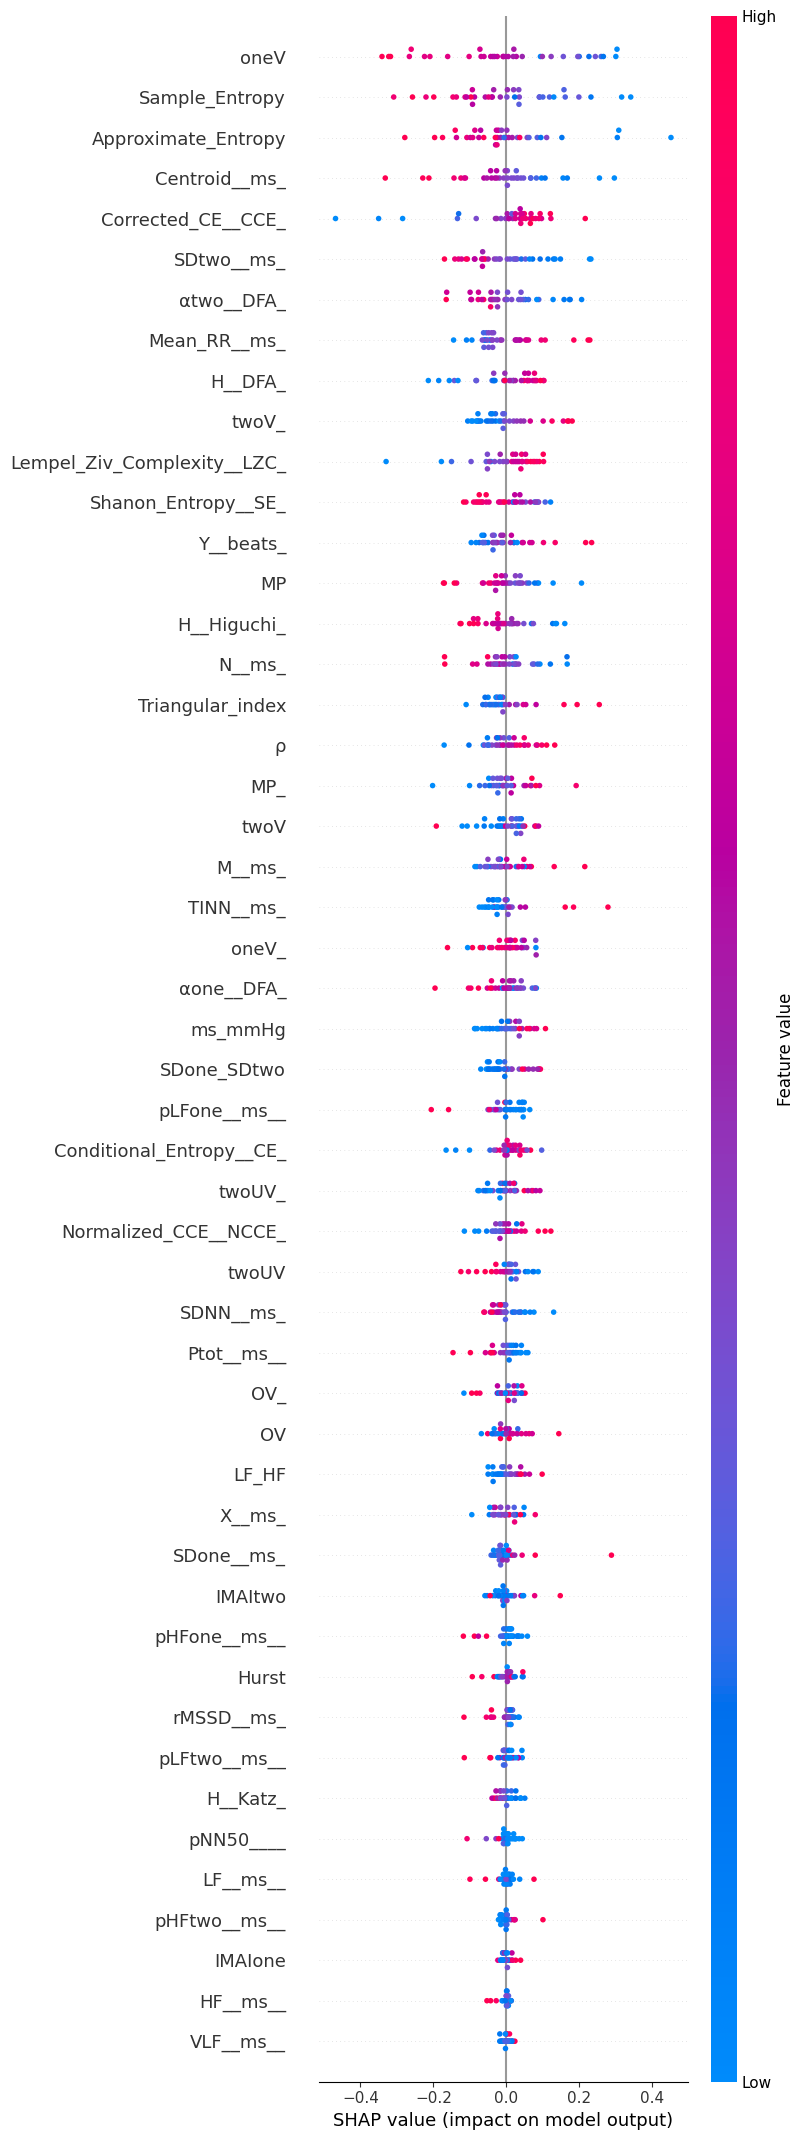

In [105]:
import shap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Initialize SHAP explainer
explainer = shap.Explainer(best_model.predict, X_test)
shap_values = explainer(X_test)

# Define the custom color palette from midnight blue to dark red
colors = ["midnightblue", "darkred"]
cmap = mcolors.LinearSegmentedColormap.from_list("blue_to_red", colors)


# Summary plot

shap.summary_plot(shap_values, X_test, max_display=50, color=plt.get_cmap("RdBu"))


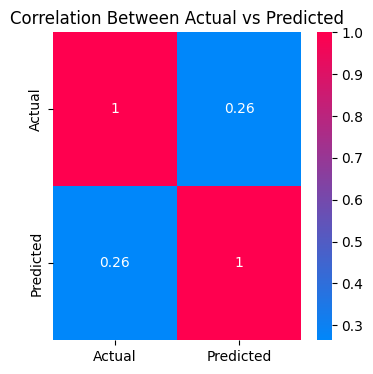

In [107]:
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns

# Create a DataFrame with actual and predicted values
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Define the custom RGB colors for light blue and pink
light_blue = (0/255, 135/255, 250/255)  # RGB (0, 135, 250)
pink = (255/255, 0/255, 79/255)        # RGB (255, 0, 79)

# Create the colormap using the specified colors
cmap = LinearSegmentedColormap.from_list('lightblue_to_pink', [light_blue, pink])


# Correlation heatmap
plt.figure(figsize=(4, 4))

sns.heatmap(results.corr(), annot=True, cmap=cmap)
plt.title('Correlation Between Actual vs Predicted')
plt.show()


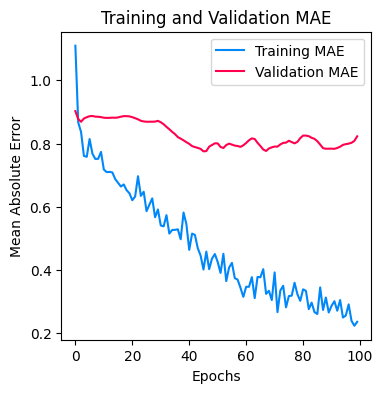

In [115]:
import matplotlib.pyplot as plt

# RGB values for light blue and light pink
light_blue = (0/255, 135/255, 250/255)  # Light blue: RGB(0, 135, 250)
light_pink = (255/255, 0/255, 79/255)  # Light pink: RGB(255, 0, 79)

plt.figure(figsize=(4, 4))
plt.plot(history.history['mae'], label='Training MAE', color=light_blue)
plt.plot(history.history['val_mae'], label='Validation MAE', color=light_pink)
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()


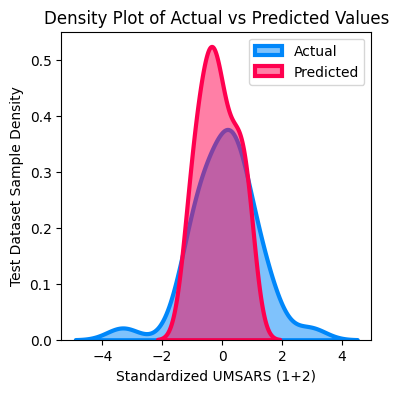

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the custom RGB colors for light blue and pink
light_blue = (0/255, 135/255, 250/255)  # RGB (0, 135, 250)
pink = (255/255, 0/255, 79/255)        # RGB (255, 0, 79)

# Density plot for actual and predicted values
plt.figure(figsize=(4, 4))
sns.kdeplot(y_test, label='Actual', color=light_blue, linewidth=3,fill=True, alpha=0.5)
sns.kdeplot(y_pred, label='Predicted', color=pink, linewidth=3,fill=True, alpha=0.5)
plt.legend()
plt.title('Density Plot of Actual vs Predicted Values')
plt.xlabel('Standardized UMSARS (1+2)')
plt.ylabel('Test Dataset Sample Density')
plt.show()


In [111]:
best_model.save("best_model.h5")

In [113]:
model_json = best_model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights
best_model.save_weights("model.weights.h5")

In [121]:
X_test.shape

(36, 50)

In [122]:
X_train.shape

(81, 50)